In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
import matplotlib.pyplot as plt
from bsccm import BSCCM
import numpy as onp
import time
from tqdm import tqdm
from encoding_information.bsccm_utils import *
from encoding_information.plot_utils import *
from encoding_information.bsccm_utils import *
from encoding_information.information_estimation import *
from encoding_information.image_utils import *
from matplotlib.colors import LinearSegmentedColormap
from jax import jit
import jax.numpy as np


bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

2023-10-27 08:11:49.757310: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-27 08:11:50.248335: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cublas/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_cupti/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_nvcc/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_nvrtc/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_runtime/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/pyth

Opening BSCCM
Opened BSCCM


## Estimate stationary gaussian processes and draw samples from them

In [27]:
# images used to generate the covariance matrix
num_images = 10000
num_patches = 10000
edge_crop = 24

patch_size = 50 # the size of patches to estimate the covariance matrix from
sample_size = 128 - 2 * edge_crop # the size of the samples to generate
num_samples = 5

# patch_size = 5
# sample_size = 10

photons_per_pixel = 150

# channels = ['LED119', 'DPC_Right', 'Brightfield']
# channels = ['LED119', 'DPC_Right']
channels = ['LED119']


image_samples_gp = {}
image_samples_pcnn = {}
noisy_patches_by_channel = {}
images_by_channel = {}

for channel_index, channel in tqdm(enumerate(channels), desc='Fitting models and sampling'):
    images = load_bsccm_images(bsccm, channel, num_images=num_images, edge_crop=edge_crop, convert_units_to_photons=True, median_filter=True)
    images_by_channel[channel] = images[:num_samples * 10]
    noisy_images = add_shot_noise_to_experimenal_data(images, photon_fraction=photons_per_pixel / np.mean(images))
    images = None # save memory

    print('getting patches')
    noisy_patches = extract_patches(noisy_images, patch_size=patch_size, num_patches=num_patches, seed=1234)
    noisy_patches_by_channel[channel] = noisy_patches[: num_samples * 10] # for display

    print('fitting stationary GP')
    gp = StationaryGaussianProcess(noisy_patches)
    _ = gp.fit(noisy_patches, verbose=True)
    cov_mat = gp.get_cov_mat()

    print('fitting PixelCNN')
    pcnn = PixelCNN()
    pcnn.fit(noisy_patches, max_epochs=25, verbose=True)

    print('generating samples for PixelCNN')
    image_samples_pcnn[channel] = pcnn.generate_samples(num_samples, sample_size, seed=channel_index * 1000, verbose=True)

    print('generating samples for stationary GP')
    image_samples_gp[channel] = gp.generate_samples(num_samples, sample_size,seed=channel_index * 1000, verbose=True)


Fitting models and sampling: 0it [00:00, ?it/s]

getting patches
fitting stationary GP
Initial validation NLL: 4.15


Epoch 1: 100%|██████████| 1/1 [00:53<00:00, 53.98s/it]


Epoch 1: validation NLL: nan


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


Epoch 2: validation NLL: nan


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


Epoch 3: validation NLL: nan


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


Epoch 4: validation NLL: nan


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


Epoch 5: validation NLL: nan
fitting PixelCNN
Initial validation NLL: 21.29


Epoch 1: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 1: validation NLL: 4.17


Epoch 2: 100%|██████████| 100/100 [00:09<00:00, 10.99it/s]


Epoch 2: validation NLL: 4.14


Epoch 3: 100%|██████████| 100/100 [00:09<00:00, 10.62it/s]


Epoch 3: validation NLL: 4.14


Epoch 4: 100%|██████████| 100/100 [00:09<00:00, 10.80it/s]


Epoch 4: validation NLL: 4.13


Epoch 5: 100%|██████████| 100/100 [00:09<00:00, 10.37it/s]


Epoch 5: validation NLL: 4.12


Epoch 6: 100%|██████████| 100/100 [00:09<00:00, 10.90it/s]


Epoch 6: validation NLL: 4.12


Epoch 7: 100%|██████████| 100/100 [00:09<00:00, 10.45it/s]


Epoch 7: validation NLL: 4.11


Epoch 8: 100%|██████████| 100/100 [00:09<00:00, 10.90it/s]


Epoch 8: validation NLL: 4.11


Epoch 9: 100%|██████████| 100/100 [00:09<00:00, 10.60it/s]


Epoch 9: validation NLL: 4.15


Epoch 10: 100%|██████████| 100/100 [00:09<00:00, 10.61it/s]


Epoch 10: validation NLL: 4.15


Epoch 11: 100%|██████████| 100/100 [00:09<00:00, 10.73it/s]


Epoch 11: validation NLL: 4.11


Epoch 12: 100%|██████████| 100/100 [00:09<00:00, 10.36it/s]


Epoch 12: validation NLL: 4.10


Epoch 13: 100%|██████████| 100/100 [00:09<00:00, 10.74it/s]


Epoch 13: validation NLL: 4.10


Epoch 14: 100%|██████████| 100/100 [00:09<00:00, 10.90it/s]


Epoch 14: validation NLL: 4.10


Epoch 15: 100%|██████████| 100/100 [00:09<00:00, 11.09it/s]


Epoch 15: validation NLL: 4.10


Epoch 16: 100%|██████████| 100/100 [00:09<00:00, 11.04it/s]


Epoch 16: validation NLL: 4.10


Epoch 17: 100%|██████████| 100/100 [00:09<00:00, 11.02it/s]


Epoch 17: validation NLL: 4.11


Epoch 18: 100%|██████████| 100/100 [00:09<00:00, 10.95it/s]


Epoch 18: validation NLL: 4.10


Epoch 19: 100%|██████████| 100/100 [00:09<00:00, 10.97it/s]


Epoch 19: validation NLL: 4.09


Epoch 20: 100%|██████████| 100/100 [00:09<00:00, 10.91it/s]


Epoch 20: validation NLL: 4.09


Epoch 21: 100%|██████████| 100/100 [00:09<00:00, 10.95it/s]


Epoch 21: validation NLL: 4.09


Epoch 22: 100%|██████████| 100/100 [00:09<00:00, 11.04it/s]


Epoch 22: validation NLL: 4.10


Epoch 23: 100%|██████████| 100/100 [00:09<00:00, 11.04it/s]


Epoch 23: validation NLL: 4.09


Epoch 24: 100%|██████████| 100/100 [00:09<00:00, 10.90it/s]


Epoch 24: validation NLL: 4.09


Epoch 25: 100%|██████████| 100/100 [00:09<00:00, 10.97it/s]


Epoch 25: validation NLL: 4.09
generating samples for PixelCNN


Generating PixelCNN samples: 100%|██████████| 80/80 [44:48<00:00, 33.61s/it]


generating samples for stationary GP


precomputing masks and variances:  62%|██████▎   | 50/80 [02:26<01:28,  2.94s/it]
Fitting models and sampling: 0it [56:34, ?it/s]


KeyboardInterrupt: 

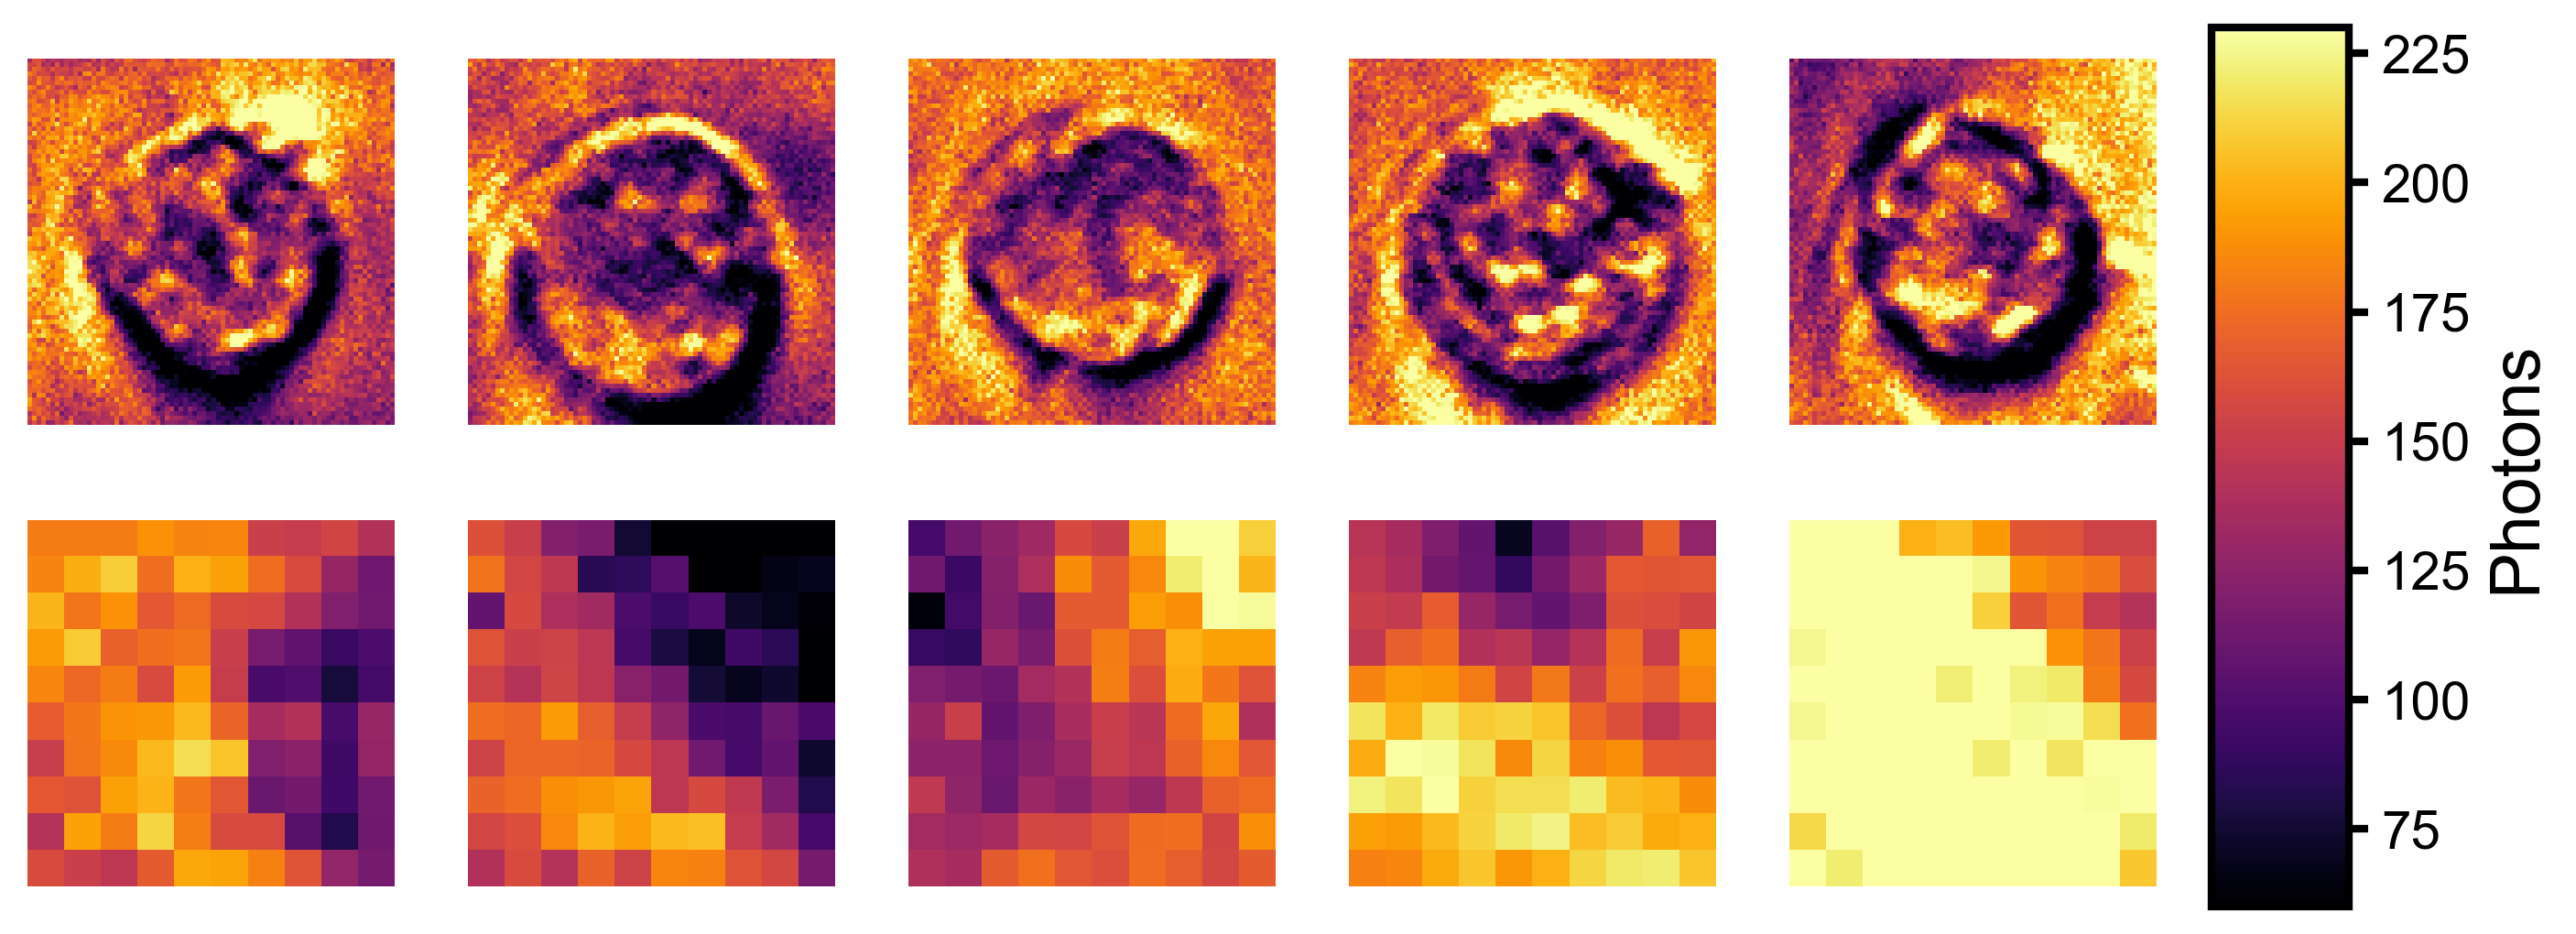

In [23]:
image_samples = image_samples_gp

# take the min and max over all channels
# concatenate all pixels for all channels from both images and samples
# then take the min and max over all pixels
all_pix = onp.concatenate([onp.array(noisy_patches_by_channel[channel]) for channel in channels])
# vmin = np.percentile(all_pix, 1)
# vmax = np.percentile(all_pix, 99)
vmin, vmax = (60, 230)

fig, image_sample_ax = plt.subplots(len(channels) * 2, num_samples, 
                                figsize=(num_samples * 2, len(channels) * 2 * 2), dpi=300)
for channel_index, channel in enumerate(channels):
    # images = patches_by_channel[channel]
    images = onp.array(images_by_channel[channel])[[1, 3, 19, 5, 11]]
    noisy_images = add_shot_noise_to_experimenal_data(images, photon_fraction=photons_per_pixel / np.mean(images))
    samples = image_samples[channel]
    for i in range(num_samples):
        im = image_sample_ax[channel_index * 2, i].imshow(noisy_images[i], cmap='inferno', vmin=vmin, vmax=vmax)
        image_sample_ax[channel_index * 2, i].axis('off')
        image_sample_ax[channel_index * 2 + 1, i].imshow(samples[i], cmap='inferno', vmin=vmin, vmax=vmax)
        image_sample_ax[channel_index * 2 + 1, i].axis('off')
        

    image_sample_ax[channel_index*2, 0].set_ylabel(channel + '\n(images)')
    image_sample_ax[channel_index*2 + 1, 0].set_ylabel(channel + '\n(samples)')

# show one big colorbar on the right side spanning all rows
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.1, 0.05, 0.8])
sm = cm.ScalarMappable(cmap='inferno', norm=plt.Normalize(vmin=vmin, vmax=vmax))
fig.colorbar(sm, cax=cbar_ax, label='Photons')

# fig.savefig('/home/hpinkard_waller/figures/mutual_information/' + 'intro_images_and_samples_gp' + '.pdf', transparent=True)

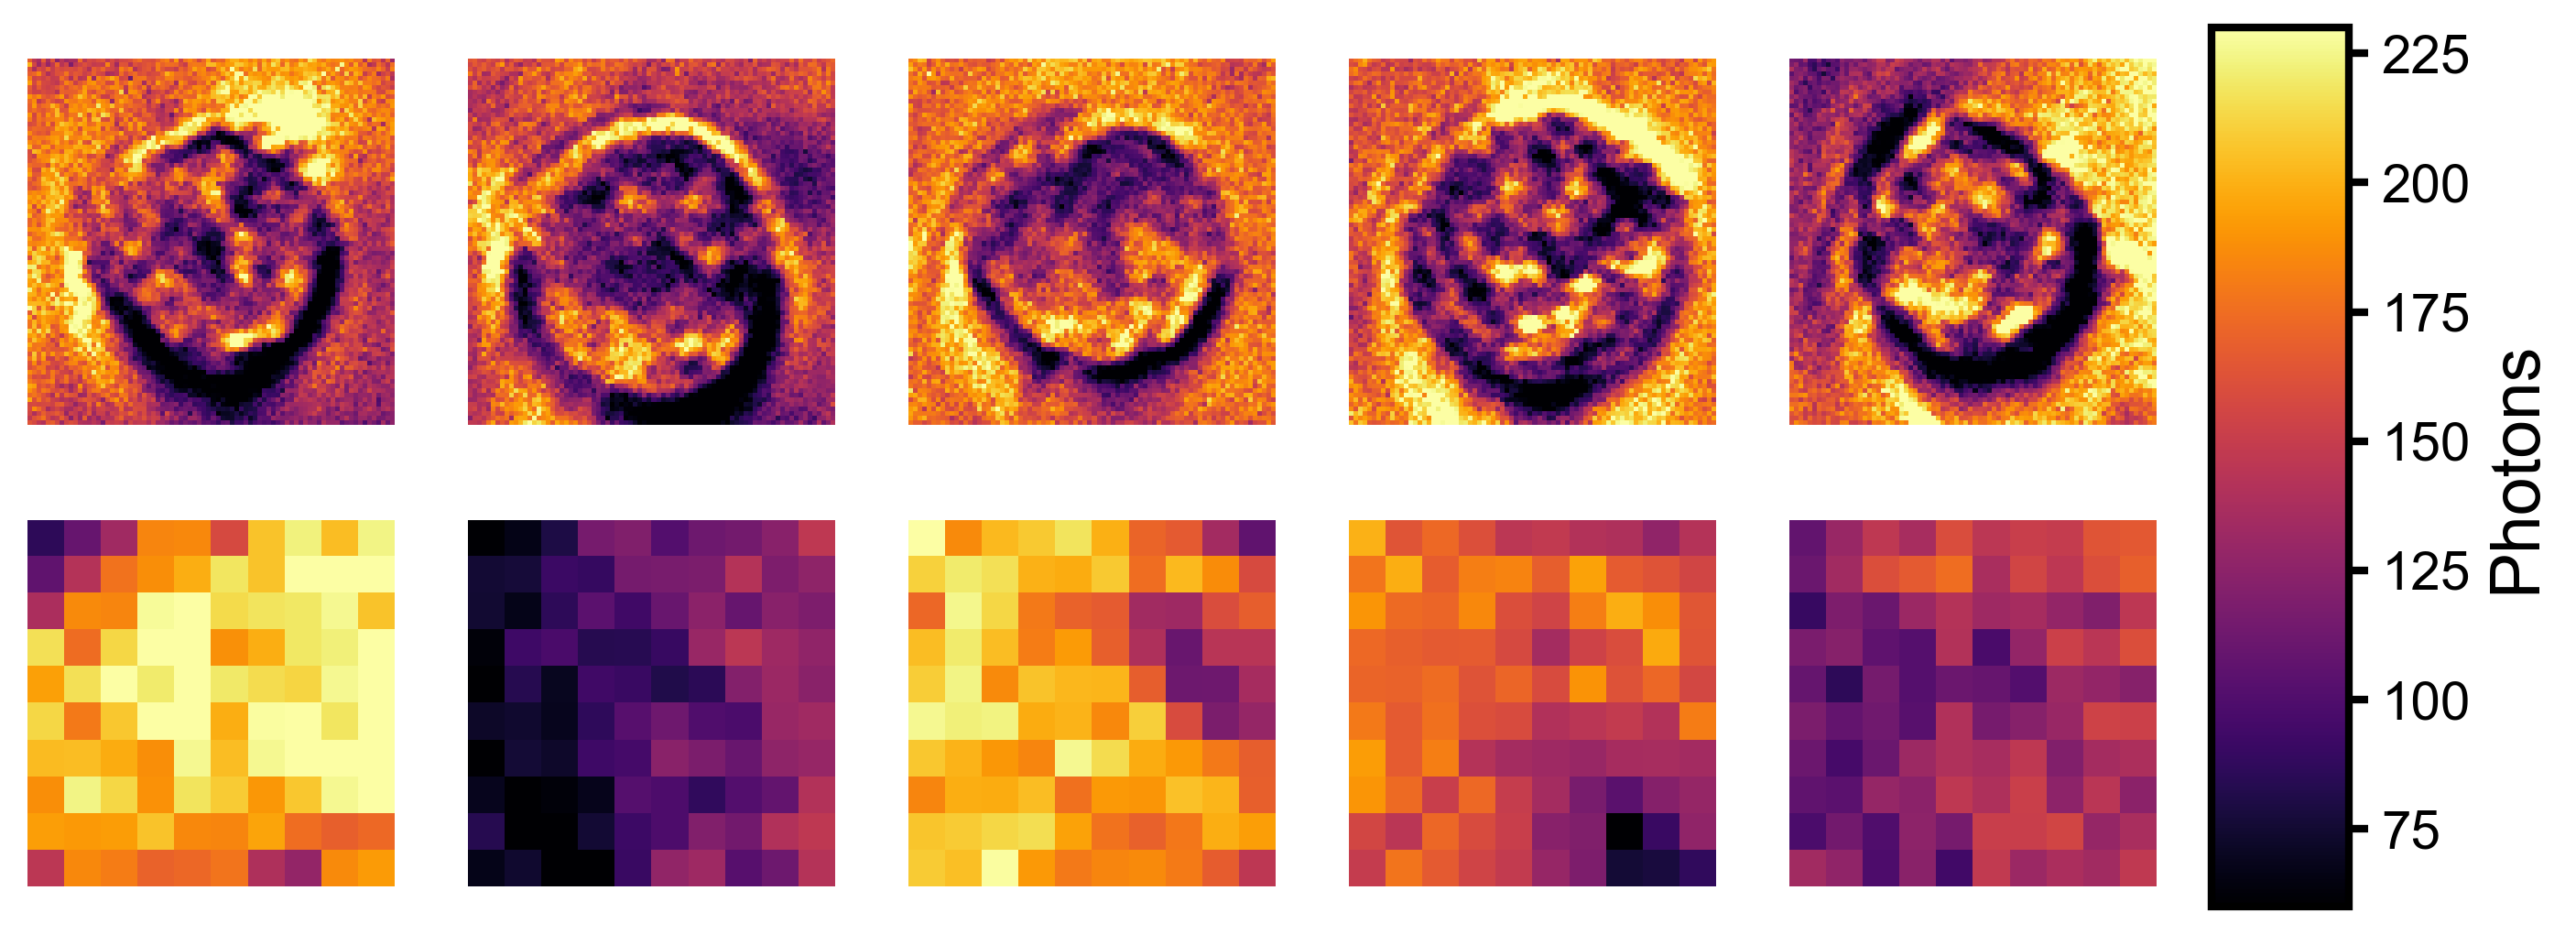

In [25]:
image_samples = image_samples_pcnn

# take the min and max over all channels
# concatenate all pixels for all channels from both images and samples
# then take the min and max over all pixels
all_pix = onp.concatenate([onp.array(noisy_patches_by_channel[channel]) for channel in channels])
# vmin = np.percentile(all_pix, 1)
# vmax = np.percentile(all_pix, 99)
vmin, vmax = (60, 230)

fig, image_sample_ax = plt.subplots(len(channels) * 2, num_samples, 
                                figsize=(num_samples * 2, len(channels) * 2 * 2), dpi=300)
for channel_index, channel in enumerate(channels):
    # images = patches_by_channel[channel]
    images = onp.array(images_by_channel[channel])[[1, 3, 19, 5, 11]]
    noisy_images = add_shot_noise_to_experimenal_data(images, photon_fraction=photons_per_pixel / np.mean(images))
    samples = image_samples[channel]
    for i in range(num_samples):
        im = image_sample_ax[channel_index * 2, i].imshow(noisy_images[i], cmap='inferno', vmin=vmin, vmax=vmax)
        image_sample_ax[channel_index * 2, i].axis('off')
        image_sample_ax[channel_index * 2 + 1, i].imshow(samples[i], cmap='inferno', vmin=vmin, vmax=vmax)
        image_sample_ax[channel_index * 2 + 1, i].axis('off')
        

    image_sample_ax[channel_index*2, 0].set_ylabel(channel + '\n(images)')
    image_sample_ax[channel_index*2 + 1, 0].set_ylabel(channel + '\n(samples)')

# show one big colorbar on the right side spanning all rows
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.1, 0.05, 0.8])
sm = cm.ScalarMappable(cmap='inferno', norm=plt.Normalize(vmin=vmin, vmax=vmax))
fig.colorbar(sm, cax=cbar_ax, label='Photons')

# fig.savefig('/home/hpinkard_waller/figures/mutual_information/' + 'intro_images_and_samples_pixel_cnn' + '.pdf', transparent=True)